In [6]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

In [7]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [67]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    #M1_dense_2 = Dense(128, activation='relu')(drop_out)
    #leaky_relu = LeakyReLU(alpha=0.3)(M1_dense_2)
    #drop_out = Dropout(0.7)(leaky_relu)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [68]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [69]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [70]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [71]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [72]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [73]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [107]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [108]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

TypeError: only size-1 arrays can be converted to Python scalars

In [117]:
from tensorflow.keras import backend as K

def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

'''def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 33, input_length=33))
    model.add(Lambda(lambda x: K.expand_dims(x, 4)))
    model.add(Conv2D(64, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.6))
    model.add(Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))
    model.add(Dropout(0.6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(768, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model'''

"def CNN_model():\n    model = Sequential()\n    model.add(Embedding(256, 33, input_length=33))\n    model.add(Lambda(lambda x: K.expand_dims(x, 4)))\n    model.add(Conv2D(64, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))\n    model.add(Dropout(0.6))\n    model.add(Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))\n    model.add(Dropout(0.6))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n    model.add(Flatten())\n    model.add(Dense(768, activation='relu', kernel_initializer='he_normal'))\n    model.add(Dropout(0.5))\n    model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))\n    model.add(Dropout(0.5))\n    model.add(Dense(1, activation='sigmoid'))\n    return model"

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 33, 21)            5376      
                                                                 
 lambda_13 (Lambda)          (None, 33, 21, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 19, 32)        1664      
                                                                 
 dropout_40 (Dropout)        (None, 17, 19, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 9, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                     

2023-05-05 16:42:03.914923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600
2023-05-05 16:42:10.997608: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


7/7 [==============================] - 14s 163ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 0.6892 - val_accuracy: 0.5359
Epoch 2/10
7/7 [==============================] - 0s 62ms/step - loss: 0.6839 - accuracy: 0.5621 - val_loss: 0.6844 - val_accuracy: 0.5112
Epoch 3/10
7/7 [==============================] - 0s 55ms/step - loss: 0.6750 - accuracy: 0.5677 - val_loss: 0.6722 - val_accuracy: 0.6166
Epoch 4/10
7/7 [==============================] - 0s 55ms/step - loss: 0.6592 - accuracy: 0.6228 - val_loss: 0.6572 - val_accuracy: 0.6883
Epoch 5/10
7/7 [==============================] - 0s 55ms/step - loss: 0.6393 - accuracy: 0.6914 - val_loss: 0.6360 - val_accuracy: 0.7085
Epoch 6/10
7/7 [==============================] - 0s 43ms/step - loss: 0.6125 - accuracy: 0.7032 - val_loss: 0.6094 - val_accuracy: 0.7220
Epoch 7/10
7/7 [==============================] - 0s 57ms/step - loss: 0.5856 - accuracy: 0.7251 - val_loss: 0.5813 - val_accuracy: 0.7309
Epoch 8/10
7/7 [====================

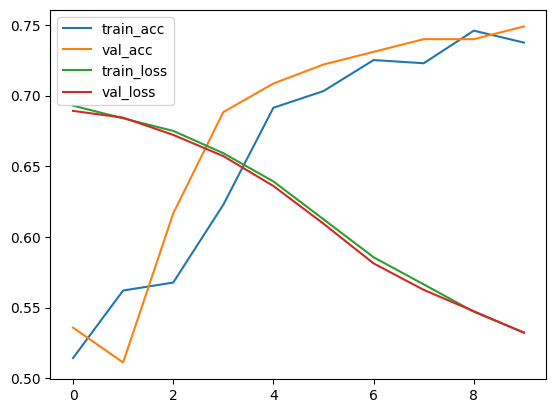


 Acc: 0.8161434977578476, MCC: 0.6324642617231876, SN:0.8018018018018018, SP:0.8303571428571429, 
 CM:[[186  38]
 [ 44 178]]
Training Embedding model...
Epoch 1/10
7/7 [==============================] - 2s 130ms/step - loss: 0.6084 - accuracy: 0.6549 - val_loss: 0.5052 - val_accuracy: 0.7691
Epoch 2/10
7/7 [==============================] - 0s 59ms/step - loss: 0.5323 - accuracy: 0.7431 - val_loss: 0.4816 - val_accuracy: 0.7848
Epoch 3/10
7/7 [==============================] - 0s 49ms/step - loss: 0.4959 - accuracy: 0.7729 - val_loss: 0.4803 - val_accuracy: 0.7937
Epoch 4/10
7/7 [==============================] - 0s 62ms/step - loss: 0.4852 - accuracy: 0.7870 - val_loss: 0.4690 - val_accuracy: 0.7982
Epoch 5/10
7/7 [==============================] - 0s 44ms/step - loss: 0.4546 - accuracy: 0.7864 - val_loss: 0.4598 - val_accuracy: 0.8161
Epoch 6/10
7/7 [==============================] - 0s 24ms/step - loss: 0.4328 - accuracy: 0.7999 - val_loss: 0.4566 - val_accuracy: 0.8117
Epoch 7/10


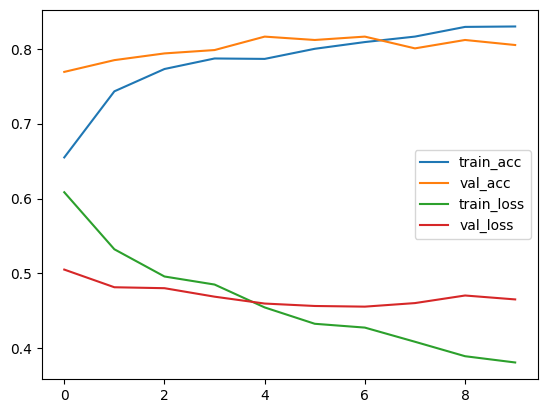


 Acc: 0.804932735426009, MCC: 0.6104254040815124, SN:0.8243243243243243, SP:0.7857142857142857, 
 CM:[[176  48]
 [ 39 183]]


In [118]:

iteration = 1
n_epo = 10

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3),
          loss=BinaryCrossentropy(),
          metrics=['accuracy'])

model_A.summary()

print("Training CNN model...")

metric = 'val_accuracy'

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo, verbose=1,callbacks=[],
    validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save('../models/cv_new/model_A_'+str(iteration)+'.h5')
model_A.save_weights('../models/model_A.h5')

y_pred = model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


########### Model B

print("Training Embedding model...")

model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,mode='auto')

metric = 'val_accuracy'

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo, verbose=1, callbacks=[], 
                        validation_data=(X_test_full_ST_embedding, test_ST_labels))

model_B.save_weights('../models/model_B.h5')

y_pred = model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))